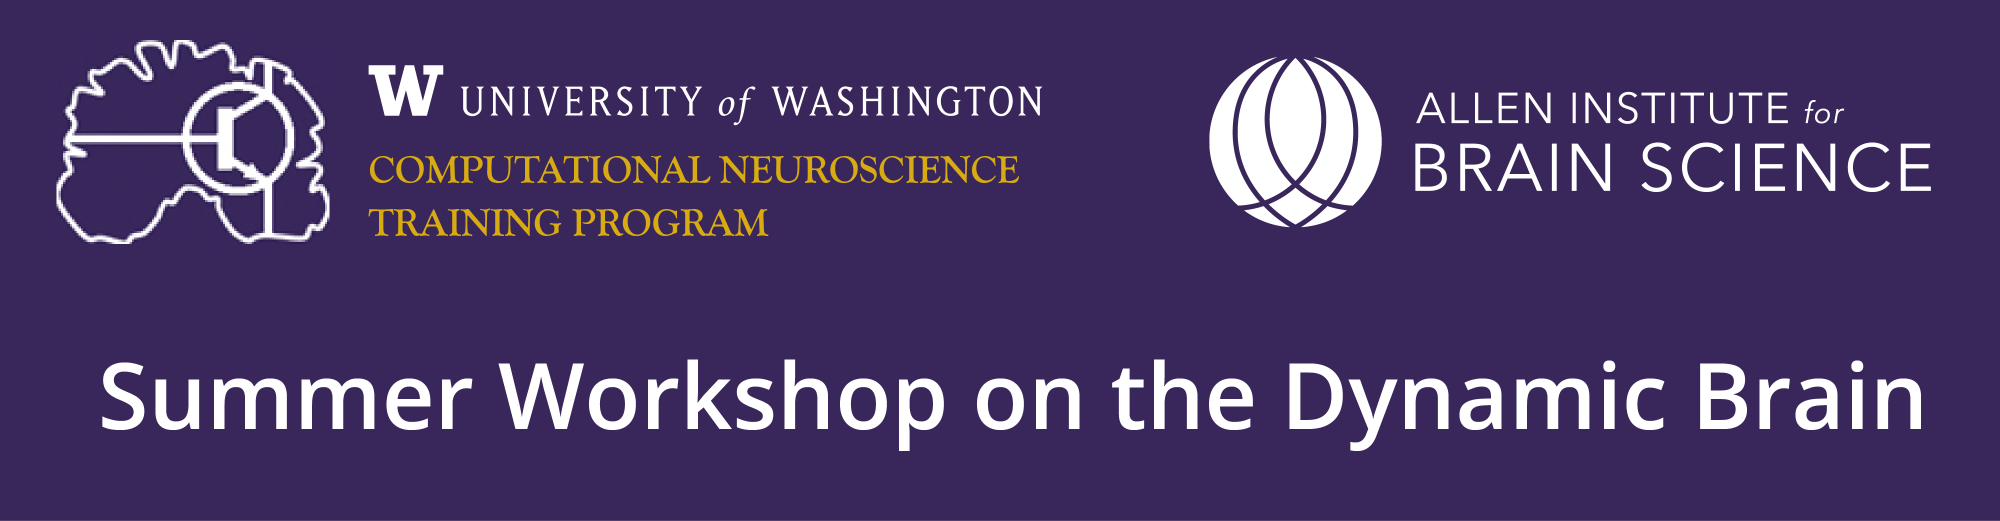 

<h1 align="center">Brain Observatory - Visual Behavior </h1> 
<h2 align="center">Summer Workshop on the Dynamic Brain </h2> 
<h3 align="center">August 24, 2021</h3> 


This notebook will introduce you to the Visual Behavior Brain Observatory dataset. This dataset uses 2-photon calcium imaging (also called optical physiology or ophys) to measure neural activity in mice performing a visual change detection task. One aim of this dataset is to ask: how is sensory coding influenced by expectation, engagement, and experience?

<h2>Image change detection task</h2>

The change detection task consists of a series of image presentations. Each image flash is 250ms followed by 500ms of gray screen. The task for the mouse is to lick in a 750ms response window following a change in image identity. On each trial, a change time is drawn from an exponential distribution between 2-8 seconds after trial start. Thus, each trial consists of multiple stimulus presentations. On go trials, a change in image identity occurs. On catch trials, no image change occurs (aka 'sham change'), and we measure false alarm rates in the same 750ms response window. Correct responses are rewarded and licks outside the response window abort the trial.

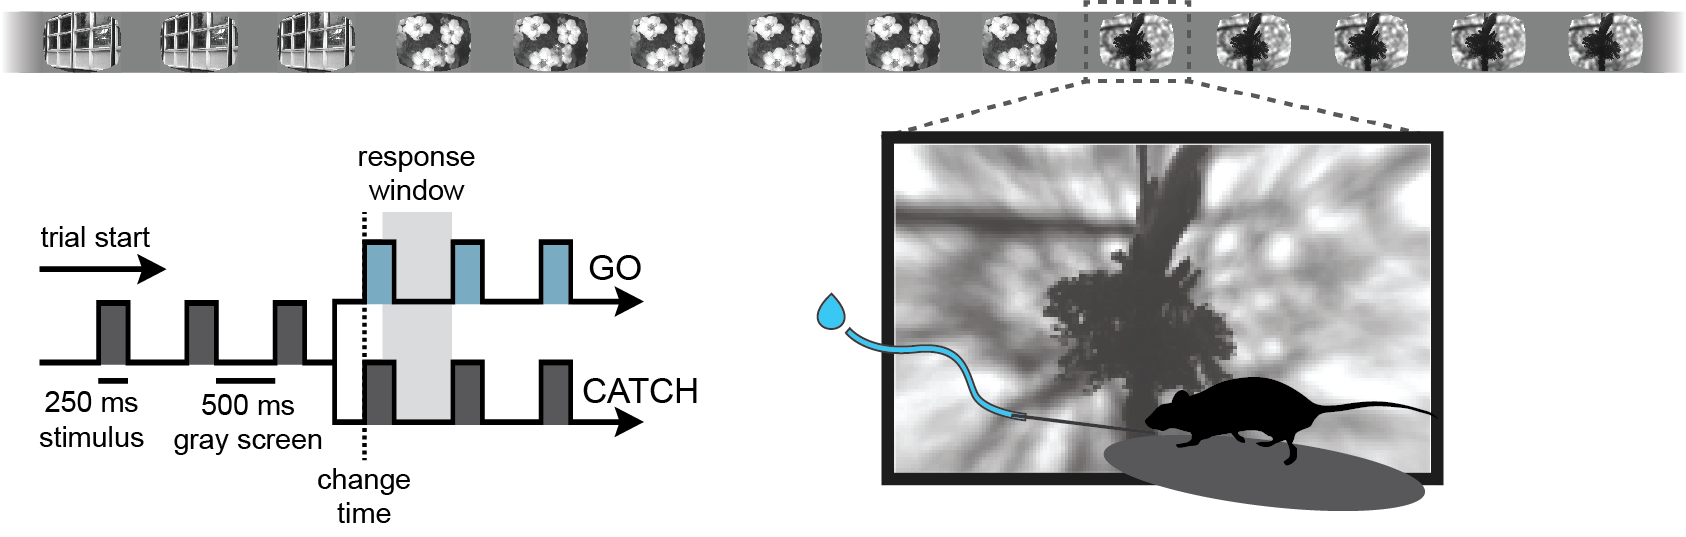

There are 8 natural scene images shown in each behavioral session. Mice learn the task first with gratings, then with a set of 8 natural scenes which become highly familiar with experience. During the imaging phase of the experiment, mice perform the task with the familiar image set, as well as another set of 8 images that are experienced for the first time under the microscope. This allows us to ask how training history and visual experience infuence sensory responses.

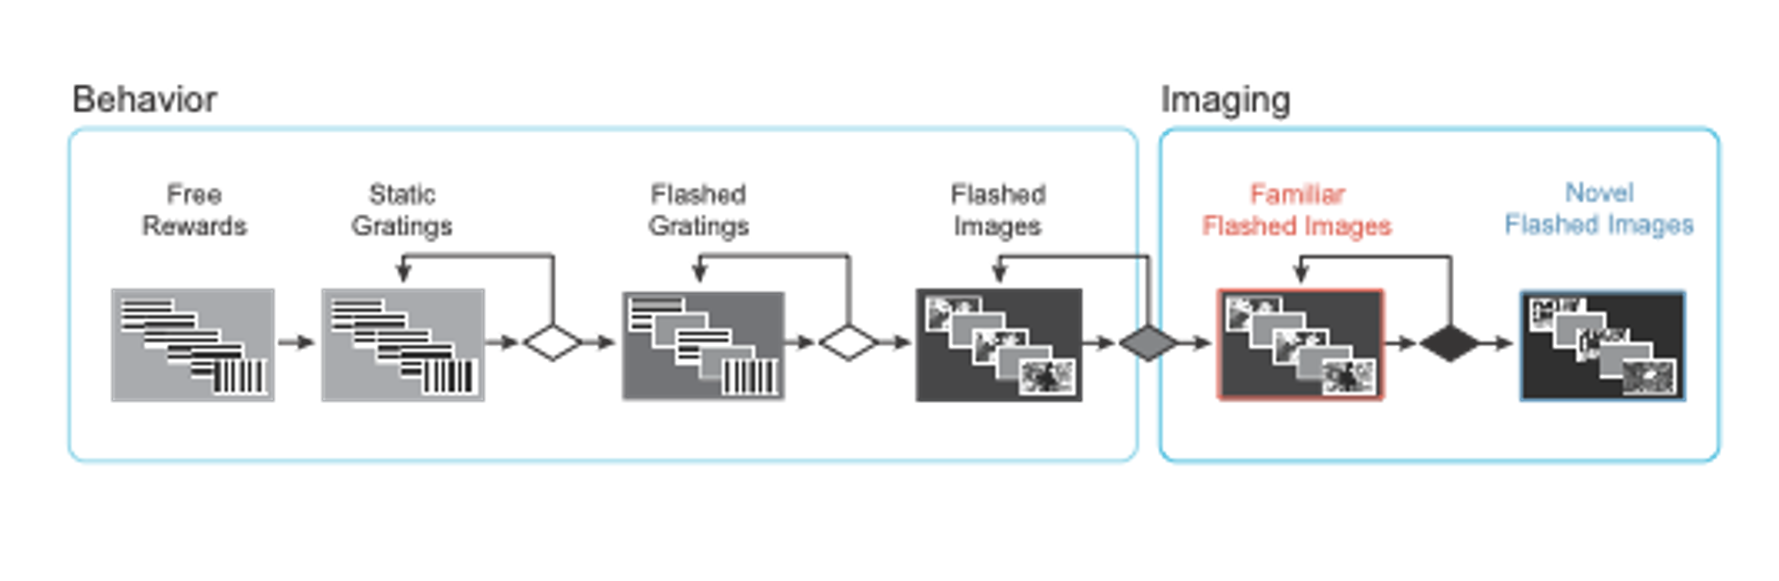

<h2>OPhys experimental design</h2>

There are 2 types of sessions during the imaging portion of the experiment - active behavior and passive viewing. During the passive viewing sessions, the task is run in open loop mode with the lick spout retracted, after the mouse has been given its daily allocation of water. This allows us to ask how representations differ when the mouse is actively engaged in the task and motivated to earn water rewards compared to when it is sated and not receiving reward feedback.

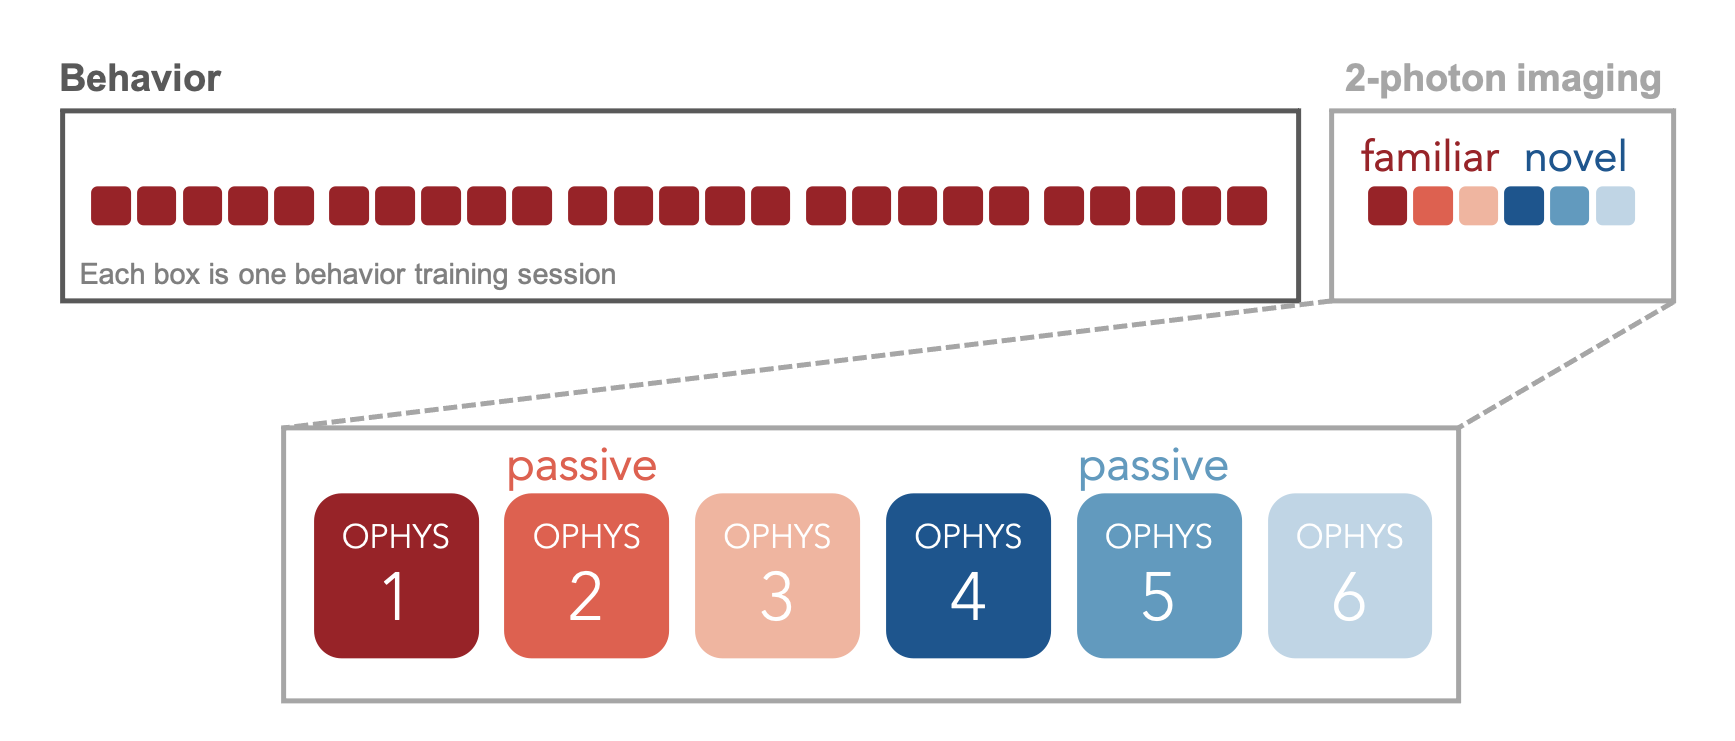

During imaging sessions, 5% of non-change image flashes are randomly omitted from the otherwise regular sequence of stimulus presentations. This allows us to ask whether expectation signals are present in the visual cortex. 

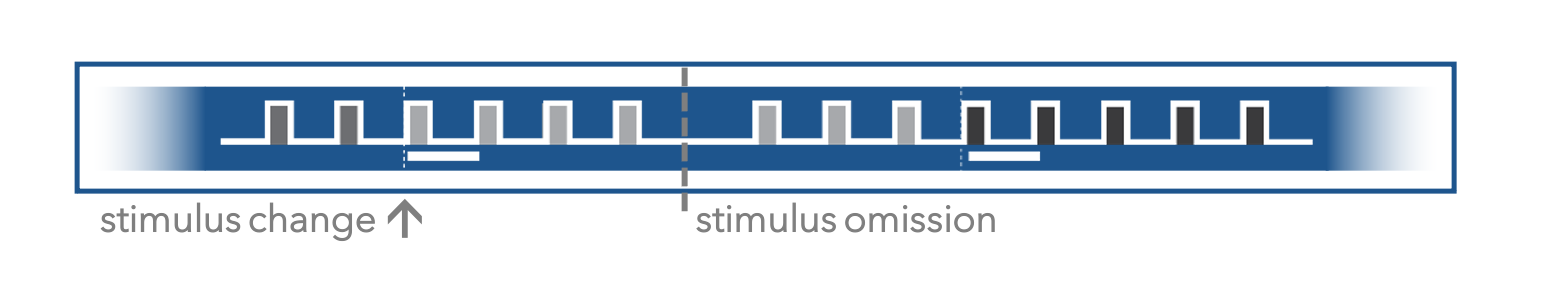

The dataset consists of recordings from excitatory (Slc17a7-IRES2-Cre;CaMK2-tTA;Ai93(GCaMP6f)), VIP inhibitory (Vip-IRES-Cre;Ai162(GCaMP6f)), and SST inhibitory (Sst-IRES-Cre;Ai162(GCaMP6f)) neurons in VISp, VISl, VISal, and VISam, sampled over multiple cortical depths. Some experiments were conducted using single-plane 2-photon imaging, while others were conducted using multi-plane 2-photon imaging to allow up to 8 imaging planes to be recorded simultaneously. 

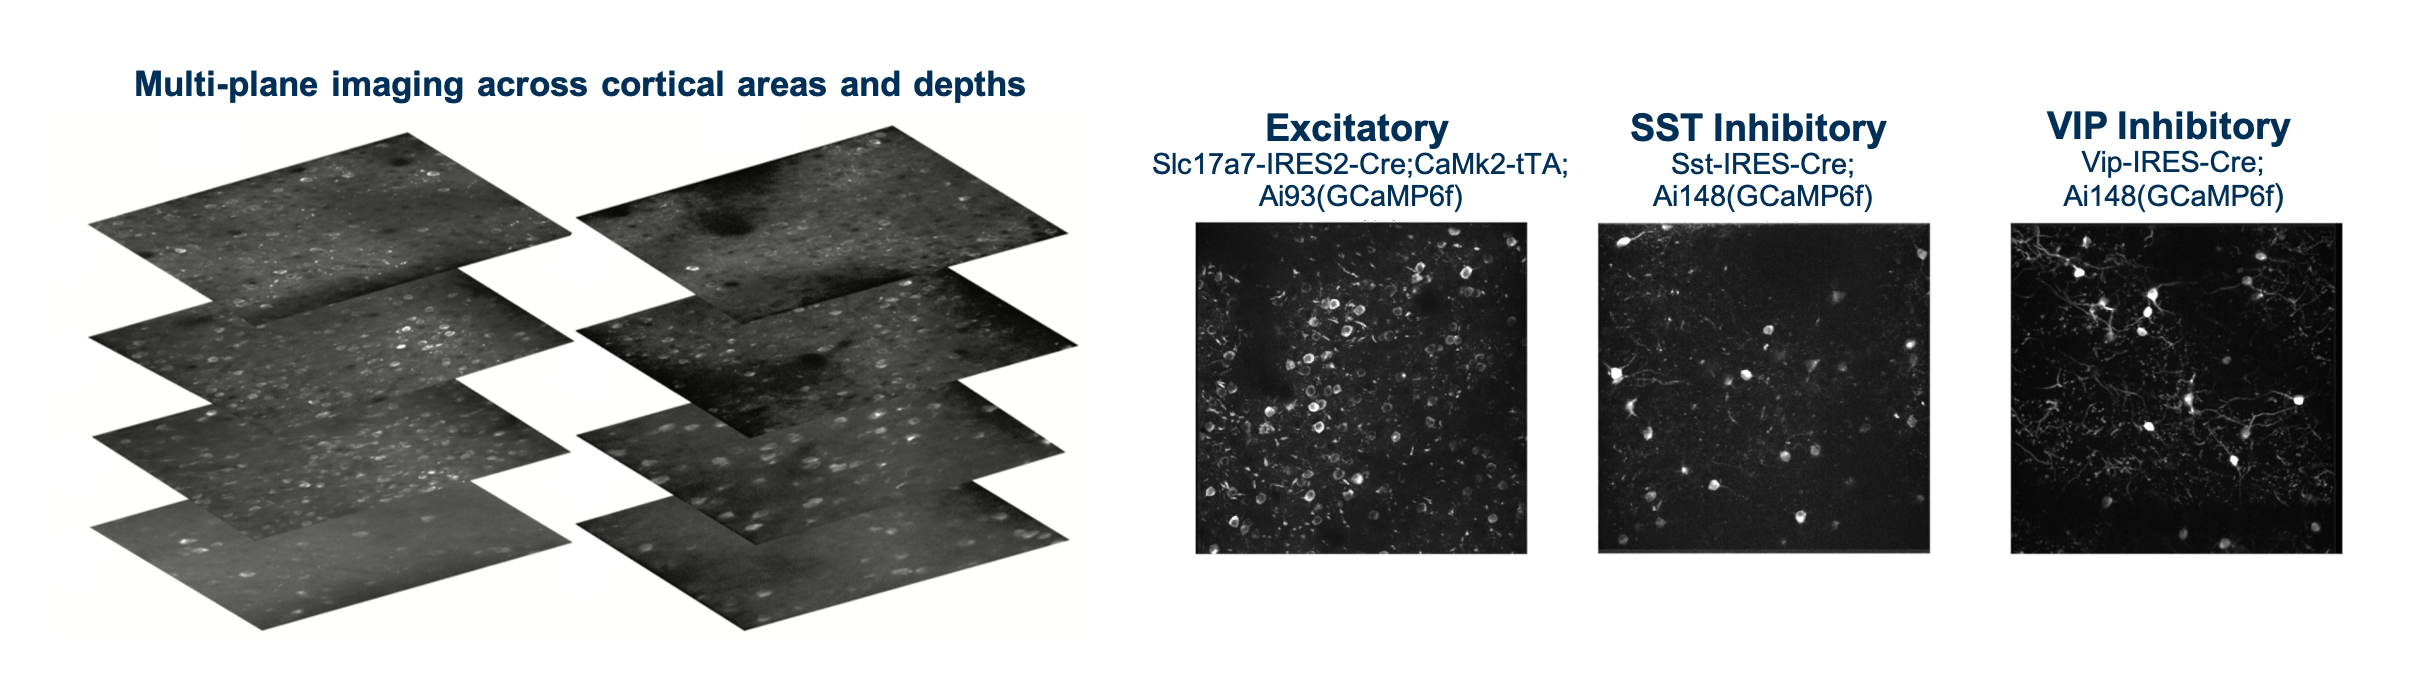

In this notebook, we will describe the core components of each experimental session and the tools for accessing and analyzing the data.

<h2>Dataset terminology</h2>
    
<p>The data collected in a single continuous recording is defined as a session. For single-plane imaging experiments, there is only one imaging plane (referred to as an experiment) per session. For multi-plane imaging experiments, there can be up to 8 imaging planes (aka 8 experiments) per session. Due to our strict QC process, not all multi-plane imaging sessions have exactly 8 experiments, as some imaging planes did not meet our data quality criteria. 
    
We aimed to track the activity of single neurons across the session types described above by targeting the same 
population of neurons over multiple recording sessions, with only one session recorded per day for a given mouse. The collection of imaging sessions for a given population of cells, belonging to a single imaging plane measured across days, is called a container. A container can include between 3 and 11 separate sessions for a given imaging plane. Mice imaged with the multi-plane 2-photon microscope can have multiple containers, one for each imaging plane recorded across multiple sessions. The session types available for a given container can vary, due to our selection criteria to ensure data quality.

Thus, each mouse can have one or more containers, each representing a unique imaging plane (experiment) that has been targeted across multiple recording sessions, under different behavioral and sensory conditions (session types).


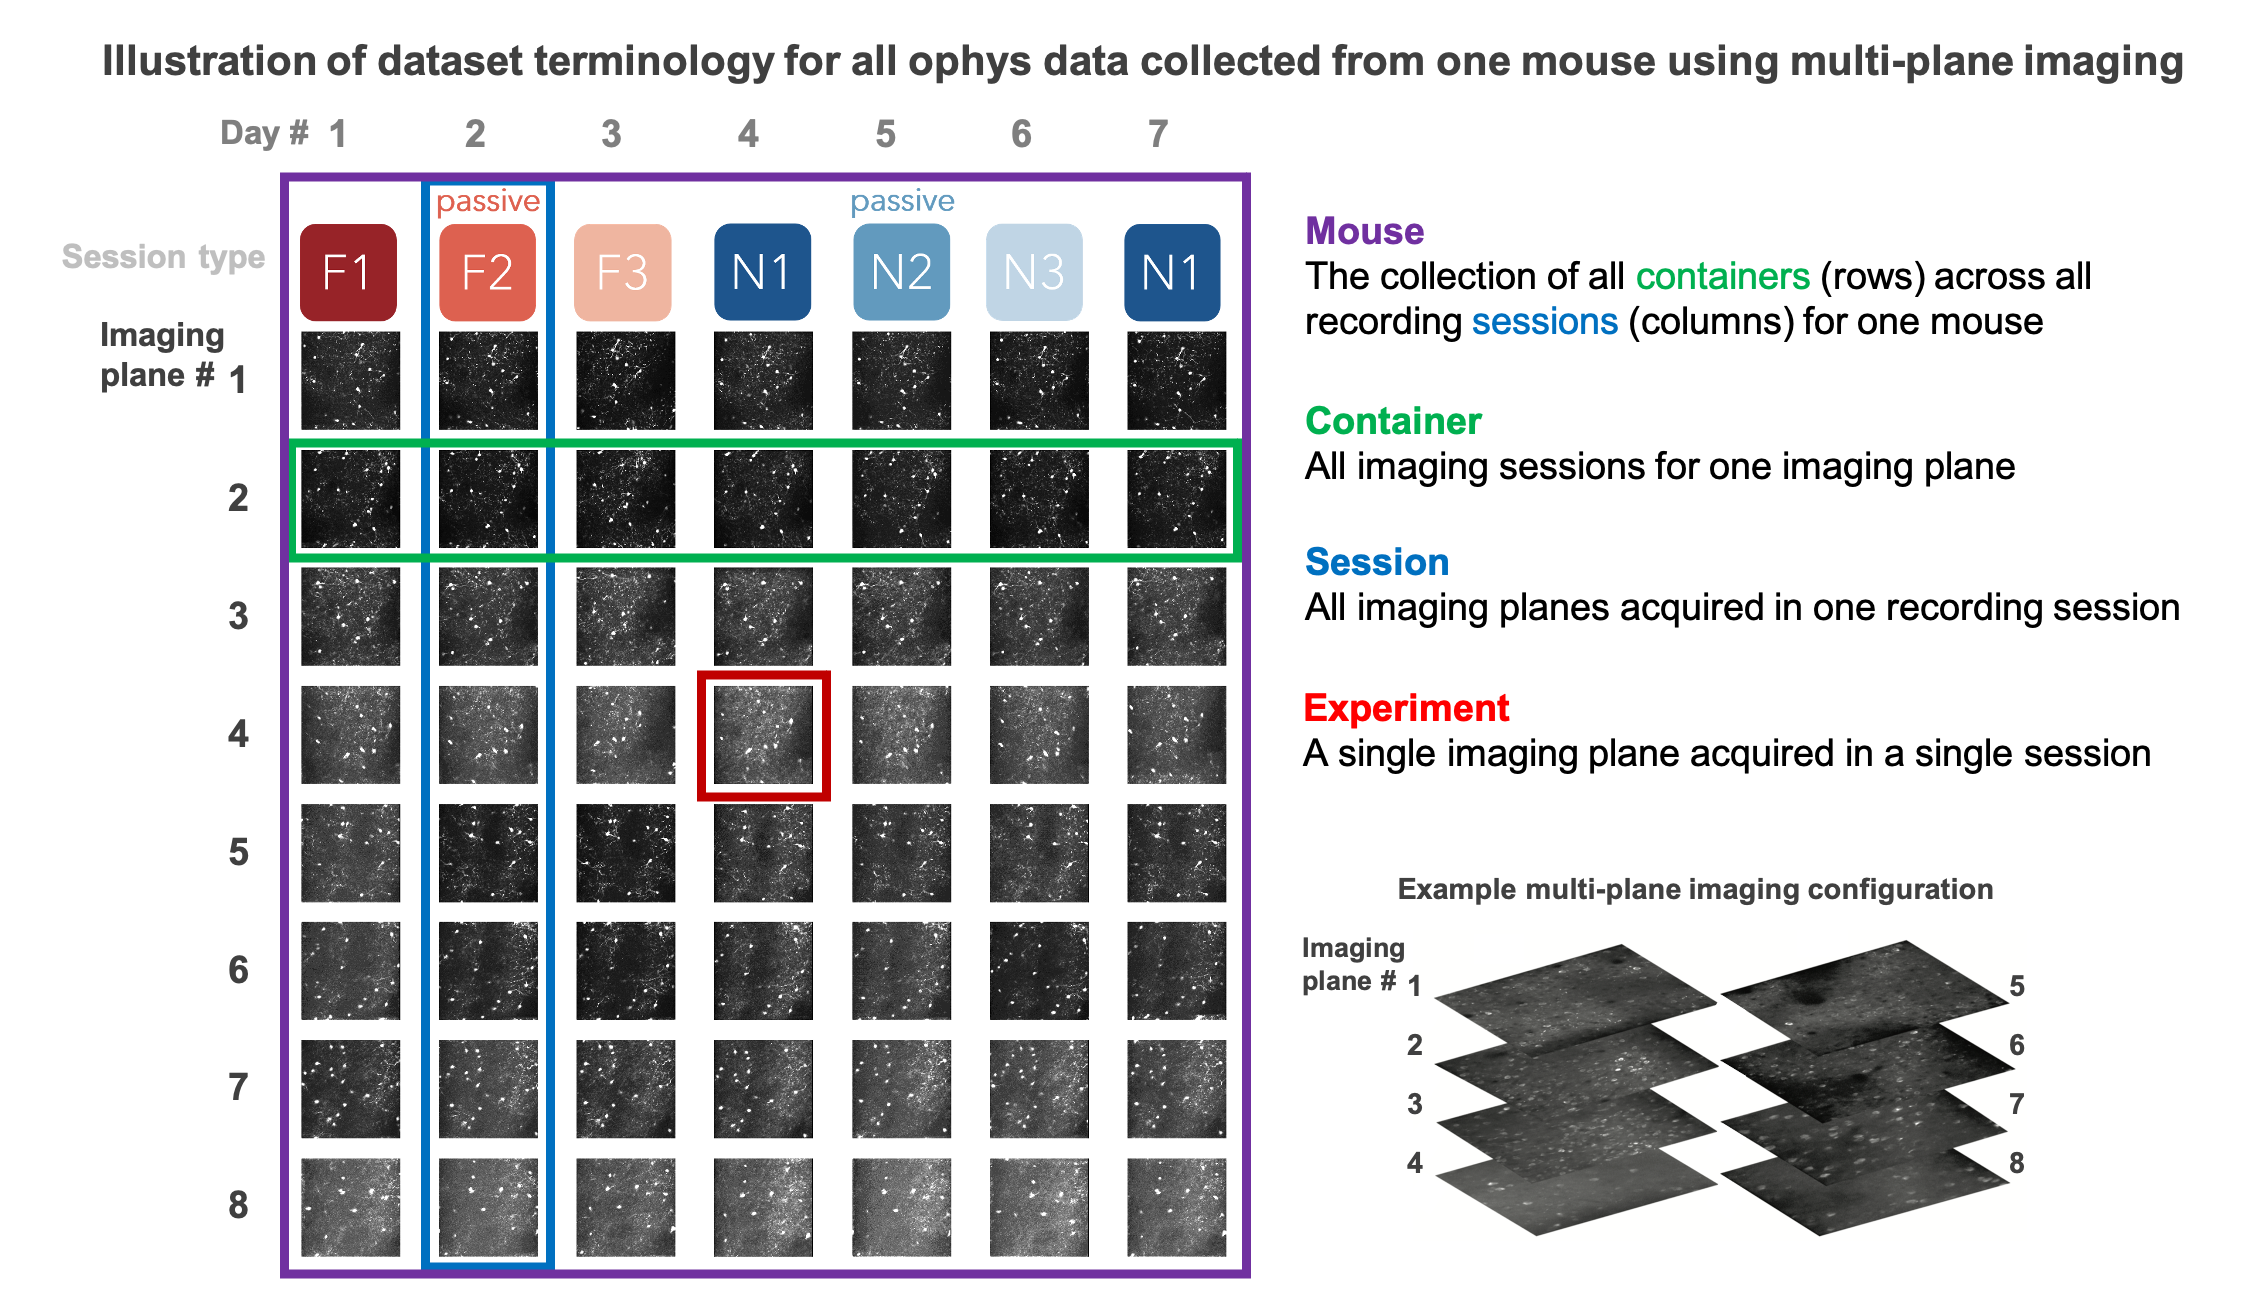

</div>

#### Imports

In [ ]:
# STANDARD PYTHON PACKAGES

# computation & data manipulation packages
import os                   # operating system
import numpy as np          # math & numbers
import pandas as pd         # dataframe & tables

# plotting and data visualization packages
import matplotlib.pyplot as plt      # basic plotting
import seaborn as sns                # fancier plotting with many built in plotting functions

In [ ]:
# ALLEN SDK
import allensdk
allensdk.__version__

In [ ]:
# cache object for loading and interacting with the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

#### set notebook & plotting aesthetic 

In [ ]:
# Jupyter notebook aesthetics
%matplotlib inline

# plotting aesthetics
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white');
sns.set_palette('deep');

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Dataset Cache Tables </h2>

<p>The first thing we will do is use the <code>allensdk</code> to load a cache for the visual behavior datasets, which contains 4 tables which provide a summary level view of all the currently released datasets. 

<p> Cache tables:

<ul><li> ophys_experiment_table
<li> ophys_session_table
<li> behavior_session_table
<li> ophys_cells_table
</ul>

<p>These tables contain roughly the same information but are organized differently. Each table is indexed by its corresponding id type (i.e. <code>ophys_experiment_table</code> uses <code>ophys_experiment_id</code> as its index.)

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>You can find a description of the metadata columns in each of these tables in the Visual Behavior cheat sheet or the SDK documentation provided here:</p> 
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>

#### load the cache

In [ ]:
import platform
platstring = platform.platform()

if ('amzn1' in platstring):
    # for AWS
    data_storage_directory = "/data/visual-behavior-ophys_data"
    # use local cache for AWS
    cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_storage_directory, use_static_cache=True)
else:  
    # for local drive, different operating systems
    if 'Darwin' in platstring:
        # OS X 
        data_root = "/Volumes/Brain2021/"
    elif 'Windows'  in platstring:
        # Windows (replace with the drive letter of USB drive)
        data_root = "E:/"
    else:
        # your own linux platform
        # EDIT location where you mounted hard drive
        data_root = "/media/$USERNAME/Brain2021/"
        data_root = "/run/media/tom.chartrand/Brain2021"
        
    # visual behavior cache directory
    cache_dir = manifest_path = os.path.join(data_root, "visual_behavior")
    # use from_s3_cache for loading from local directory
    cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=cache_dir)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.1:  Load and explore the cache tables </b></p>
    
<p>1) Load the <code>ophys_experiment_table</code>, <code>ophys_session_table</code>, and <code>behavior_session_table</code> using the <code>cache.get__fill in the blank__table() </code>.</p>
    
<p>2) List all columns of each table using pandas <code>.columns</code></p>
    
<p>3) Compare the column values across the different tables. What is in common between the different tables?</p>
    
<p> Hint: The cheat sheet is handy to help you quickly identify what columns are in what tables</p>
</div>

#### ophys_experiment_table

<p>The <code>ophys_experiment_table</code> contains metadata describing all 2-photon experiments, each conducted at a specific cortical location (<code>targeted_structure</code>) and <code>imaging_depth</code>. Each 2-photon field of view (imaging plane) was imaged over multiple sessions (each with a uique <code>ophys_session_id</code>), and will have a unique <code>ophys_experiment_id</code> in each session.</p>

The <code>ophys_container_id</code> is a unique identifier for a given imaging plane that was imaged over multiple sessions. Thus each <code>ophys_container_id</code> will correspond to multiple <code>ophys_experiment_ids</code>, all corresonding to the same 2-photon field of view imaged across multiple sessions. A given <code>ophys_experiment_id</code> will always be unique to a single ophys container. </p>

In [ ]:
ophys_experiment_table = cache.get_ophys_experiment_table()
ophys_experiment_table.head()

In [ ]:
# what are the columns of the ophys_experiment_table? 


#### ophys_session_table



<p><code>ophys_session_table</code> contains the same information as the <code>ophys_experiment_table</code>, but organized by <code>ophys_session_id</code>. If Multiscope was used, one ophys session may contain up to 8 unique <code>ophys_experiment_ids</code>. Each <code>ophys_session_id</code> will also have a unique <code>behavior_session_id</code>.</p>


In [ ]:
ophys_session_table = cache.get_ophys_session_table()
ophys_session_table.head()

In [ ]:
# what are the columns of the ophys_session_table? 


#### behavior_session_table

<p>The <code>behavior_session_table</code> contains metadata describing all behavioral sessions, during training and during 2-photon imaging. This can be used to track the behavioral training history of each mouse. You can use the <code>session_type</code> column to determine whether a session was during training or ophys</p>
    
<p></p>    
<p>Due to our ophys Quality Control process, some ophys sessions, or specific ophys experiments (imaging planes) within a session may not be released. However, behavior data is available for all sessions, regardless of whether there was ophys data or not. Behavior sessions that have an <code>ophys_session_id</code> have released ophys_data. 
    

In [ ]:
behavior_session_table = cache.get_behavior_session_table()
behavior_session_table.head()

In [ ]:
# what are the columns of the behavior_session_table?


#### ophys_cells_table

<p>The <code>ophys_cells_table</code> contains the unique IDs of all cells recorded across all experiments. You can use this table to determine which ophys experiments a given cell was matched in. 
    
<p>The <code>cell_roi_id</code> index contains a unique roi ID for each cell segmented in each ophys experiment.</p>
<p>The <code>cell_specimen_id</code> is a unique ID for each cell that is shared across all ophys experiments  that cell was recorded in. </p>
<p>Thus, a cell that was imaged in more than one experiment has multiple <code>cell_roi_ids</code> but one <code>cell_specimen_id</code>.</p>

In [ ]:
ophys_cells_table = cache.get_ophys_cells_table()
ophys_cells_table.head()

In [ ]:
# What are the columns of the ophys_cells_table? What could this table be used for? 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task 1.2 Exploring and filtering the <code>ophys_experiment_table</code> </b></p>
    
<p>Using the <code>ophys_experiment_table</code>, do the following: </p>
 
<p>1) List all unique entries for the<code>cre_line</code> column and the <code>full_genotype</code> column using the pandas <code>.unique()</code> method. Are they the same length? What is different about them? </p>

<p>2) List all unique entries for the<code>project_code</code> column </p>
    
<p>3) Select a specific <code>project_code</code>, filter the table by that value, and assign it to a new variable</p>
    
<p>4) In your filtered table, list all unique entries for the<code>targeted_structure</code> column </p>

<p>5) In your filtered table, list all unique entries for the<code>session_type</code> column </p>

<p>6) Repeat for a different <code>project_code</code>. What are the differences?  </p>
</div>

In [ ]:
# print out the unique values of cre_line in this table


In [ ]:
# print out the unique values of full_genotype in this table


In [ ]:
# print out the unique values of project_code in this table


In [ ]:
# filter to select one project code


In [ ]:
# print out what is available for targeted_structure and session_type


In [ ]:
# try for another project code - what is different?


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task 1.3 Exploring and filtering the <code>behavior_session_table</code></b></p>
    
<p>Using the <code>behavior_session_table</code>, do the following:</b></p>
 
<p>1) Count the total number of unique mice available using the <code>mouse_id</code> column and pandas <code>.unique()</code> method</p>

<p>2) Select a <code>mouse_id</code> at a random using pandas <code>.sample()</code> and then filter the table based on that <code>mouse_id</code> </p>

<p>3) List all the values of <code>session_type</code> for that mouse</p>
    
<p>4) Behavior sessions that also have ophys data have an <code>ophys_session_id</code>. Use the pandas method <code>.isnull()</code> to determine how many sessions have an <code>ophys_session_id</code> and which do not. </p>

<p> Hint: the pandas cheat sheet provides examples of each of these methods. You can also find more documentation here: 

__[Pandas documentation ](https://pandas.pydata.org/docs/reference/index.html)__ </p>

</div>

In [ ]:
# how many mice? 


In [ ]:
# get a random mouse id
random_index = behavior_session_table.sample(1).index[0]
random_mouse_id = behavior_session_table['mouse_id'][random_index]

# filter the behavior table & display it
mouse_behavior_table = behavior_session_table[behavior_session_table["mouse_id"]==random_mouse_id]
mouse_behavior_table.head()

In [ ]:
# what are the session_types available for this mouse? 


In [ ]:
# how many sessions have ophys data? 
sessions_with_ophys = mouse_behavior_table[mouse_behavior_table.ophys_session_id.isnull()==False]
print(len(sessions_with_ophys), 'sessions have ophys data')

In [ ]:
# how may sessions do not have ophys data? 
sessions_without_ophys = mouse_behavior_table[mouse_behavior_table.ophys_session_id.isnull()==True]
print(len(sessions_without_ophys), 'sessions do not have ophys data')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task 1.4 Exploring the <code>ophys_cells_table</code></b></p>
 
<p>1) Select a specific <code>cell_specimen_id</code> and filter the <code>ophys_cells_table</code> to get all the <code>ophys_experiment_id</code>s a cell was matched across. </p>
    
<p>2) Try again for a few more random <code>cell_specimen_id</code>s. How many <code>ophys_experiment_id</code>s, aka unique imaging planes, do they have? Find a <code>cell_specimen_id</code> that was matched in more than 4 experiments.</p> 
    
<p>3) Add experiment metadata to the <code>ophys_cells_table</code> using the pandas <code>.join()</code> method to join the <code>ophys_experiment_table</code> with the <code>ophys_cells_table</code>, joining on <code>ophys_experiment_id</code></p>
    
<p>4) What are the <code>session_type</code>s that your <code>cell_specimen_id</code> was present in? Were any <code>session_type</code>s repeated more than once? </p>
    

</div>

In [ ]:
# load ophys_cells_table from the cache


In [ ]:
# get a random cell_specimen_id
random_index = ophys_cell_table.sample(n = 1).index[0]
random_cell_specimen_id = ophys_cell_table["cell_specimen_id"][random_index]

# filter the cell table to get all occurances of specific cell_specimen_id
ophys_cell_table[ophys_cell_table["cell_specimen_id"] == random_cell_specimen_id]

In [ ]:
# try again for another cell_specimen_id. How many experiments is it matched in? 


In [ ]:
# join ophys_cells_table with ophys_experiment_table
ophys_cell_table = ophys_cell_table.join(ophys_experiment_table, on='ophys_experiment_id')
ophys_cell_table.head()

In [ ]:
# what session_types was your cell_specimen_id matched in? 
ophys_cell_table[ophys_cell_table["cell_specimen_id"] == random_cell_specimen_id].session_type.values


<p>Because each cell is associated with a single field of view (imaging plane), each <code>cell_specimen_id</code> will belong to a single <code>ophys_container_id</code>, which links all <code>ophys_experiment_ids</code> for a given imaging plane across sessions. </p>

<p>If a cell was not active in a particular session and was not detected by our segmentation algorithm, which relies on cell activity to identify ROIs, then that cell's <code>cell_specimen_id</code> will not be present in that session. In other words, not all cells are present in all sessions for a given mouse.</p>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.5:  What is in an ophys container? </b></p>

<p>The Ophys Experiment Container describes a set of imaging sessions recorded from the same 2-photon field of view, targeting the same population of neurons. All the sessions in an ophys container have a common <code>ophys_container_id</code>,  but a unique <code>ophys_experiment_id</code> within each session.</p>

<p> Using the <code>ophys_experiment_table</code> do the following:</p>

<p> 1) Get the <code>ophys_container_id</code> for one <code>ophys_experiment_id</code> and find out what other sessions were recorded from that same field of view. </p>
    
<p> 2) Use pandas <code>.groupby()</code> and <code>.get_group()</code> to see what other experiments are in that specific container</p>
    
<p> 3) Get the number of experiments associated with each container by using  <code>.groupby</code> and <code>.size()</code>. Do all containers have the same number of experiments associated with them? </p>

</div>

In [ ]:
# get the container ID for this experiment
random_ophys_exp_id = ophys_experiment_table.sample(1).index[0]

container_id = ophys_experiment_table['ophys_container_id'][random_ophys_exp_id]

In [ ]:
# what other ophys experiments are in this container?
ophys_experiment_table.groupby('ophys_container_id').get_group(container_id)

In [ ]:
# Get number of sessions in each container using .groupby()


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Reminder:</b> You can find a description of the metadata columns for all cache tables in the Visual Behavior cheat sheet or the SDK documentation provided here:</p>
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Dataset Object Types </h2>

Visual Behavior has 2 types of dataset objects:
<ul><li> Behavior Session Dataset
<li> Behavior Ophys Experiment Dataset
</ul>

<p><b>Behavior Session Dataset:</b> contains the data streams associated with the behavior of the mouse and its task performance. For behavior sessions, all data is sampled at 60Hz (the stimulus frame rate), and are referenced relative to the start of the stimulus.</p>
<p><b>Behavior Ophys Experiment Dataset:</b> contains 2-photon optical physiology data for all cells recorded in a single imaging plane in a single session, in addition to all behavioral data streams available in the Behavior Session, as well as pupil tracking information. Ophys experiments have data streams sampled at different rates (ophys at 11Hz or 30Hz, stimulus and behavior at 60Hz, pupil tracking at 30Hz), aligned to a common time clock. </p>

<p>During the training of the mice, only behavior data was collected, and thus, training sessions only have Behavior Session datasets. However, a behavior + optical physiology session has both a Behavior Session dataset and an Ophys Experiment dataset. Optical physiology experiments that did not pass ophys QC still have a Behavior Session dataset so that animal performance can be tracked even in the absence of ophys data.


 __[Documentation for Visual Behavior Datasets](https://alleninstitute.sharepoint.com/:w:/r/sites/VisualBehaviorAIBS/_layouts/15/guestaccess.aspx?e=Jm7GmA&share=EUkWXB9X8wZKleIGtsviscMBTgesWXsrHESs84Ye9FvqzQ)__</p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.1 Loading a Behavior Session dataset</b></p>
    
<p> 1) Load a Behavior Session Dataset for some <code>behavior_session_id</code> the cache method <code>.get_behavior_session()</code></p>
<p> 2) Get a list of available attributes for that behavior_session dataset using <code>.__dict__.keys()</code></p>
<p> 3) What is in the <code>task_parameters</code> attribute of your behavior session? </p>

</div>

In [ ]:
# load the behavior session table from the cache


In [ ]:
# get some behavior_session_id


In [ ]:
# load a behavior session dataset using the cache method listed in the task instructions
# assign it to a variable called behavior_session


In [ ]:
# check what attributes are available for a behavior session


In [ ]:
# what are the task_parameters for this behavior session? 


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 2.2 Loading an Ophys Experiment dataset</b></p>
    
<p> 1) Load an Ophys Experiment Dataset for some <code>ophys_experiment_id</code> using the cache method <code>.get_behavior_ophys_experiment()</code></p>

<p> 2) Get a list of available attributes for that Ophys Experiment Dataset using <code>.__dict__.keys()</code>. Compare the attributes with the Behavior Session above. What is the same and different? </p>
        
</div>

In [ ]:
# load the ophys_experiment_table from the cache
ophys_experiment_table = cache.get_ophys_experiment_table()

In [ ]:
# pick some ophys_experiment_id
selected_ophys_experiment_id = ophys_experiment_table.index.values[0]

In [ ]:
# load a behavior ophys experiment using the cache method listed in the task instructions
# assign it to a variable called ophys_experiment


In [ ]:
# what attributes are present for an ophys_experiment? 
experiment_attributes = sorted(list(ophys_experiment.__dict__.keys()))
experiment_attributes

In [ ]:
# what is different between the attributes for the behavior session above and this behavior ophys experiment? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>You can find a description of all <code>behavior_session</code> and <code>ophys_experiment</code> attributes in the Visual Behavior cheat sheet or the SDK documentation provided here:</p>
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior Ophys Experiment Dataset</h2>

<p> For the remainder of the notebook we will explore the Behavior Ophys Experiment dataset. We have chosen to do so because it contains all of the attributes found in the Behavior Session dataset PLUS attributes related to 2-photon calcium imaging and cell physiology. Therefore any tasks utilizing attributes found in the Behavior Session dataset would be common to both datasets. </p>
    
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.1:  What data is available for an Ophys Experiment Dataset? </b></p>

<p>Use tab completion to see what is in the dataset object for an experiment </p>

<p> 1) What is in the <code>metadata</code> attribute? </p>

<p> 2) Use the built in help function to explore documentation for your behavior ophys experiment</p>

</div>


In [ ]:
# get ophys_experiment metadata


In [ ]:
# what is in the documentation for your ophys_experiment? use the help function


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Optical physiology data - max projection, roi masks, and fluorescence traces</h2>

<p>Let's use the ophys experiment object to access neuron fluorescence timeseries, roi masks, and metadata. An ROI mask is used to define the boundary of each cell in the flourescence data. The timeseries extracted from each ROI is one cell's activity.</p>

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.2: Max intensity projection and ROI masks</b></p>
    
<p>1) Get the maximum intensity projection image using the <code>max_projection</code> attribute for your ophys_experiment dataset and display it. </p>

<p> The maximum intensity projection shows the maximum fluorescence value for each pixel in the 2-photon movie across the entire session.</p>
    
<p>2) Get the <code>segmentation_mask_image</code> and display it next to the max projection.</p>

<p> The segmentation mask image is a binary mask showing the segmented ROIs corresponding to detected neurons in the imaging plane</p> 
</div>

In [ ]:
# what does the max_projection attribute look like? 


In [ ]:
# plot the max intensity projection and the segmentation mask
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

ax[0].imshow(ophys_experiment.max_projection, cmap='gray')
ax[1].imshow(ophys_experiment.segmentation_mask_image)
plt.tight_layout()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">   
 
<p><b>Task 3.2 continued</b></p>
<p>3) What is the index of the <code>cell_specimen_table</code> attribute? </p>
<p>4) Get and display the mask for a single cell from the <code>roi_mask</code> column in the <code>cell_specimen_table</code> attribute. What other columns does cell <code>cell_specimen_table</code> have? </p>
</div>

In [ ]:
# get cell_specimen_table attribute of ophys_experiment
cell_specimen_table = ophys_experiment.cell_specimen_table.copy()

In [ ]:
# what does cell_specimen_table look like? 
cell_specimen_table.head()

In [ ]:
# what are the columns?
cell_specimen_table.columns

In [ ]:
# get a random cell_specimen_id
random_index = np.random.randint(0, high = len(cell_specimen_table) - 1, size = 1)[0]
random_cell_specimen_id = cell_specimen_table.index[random_index]

In [ ]:
# plot the roi_mask for this cell_specimen_id
plt.imshow(cell_specimen_table["roi_mask"][random_cell_specimen_id])

    
<p>The <code>cell_specimen_table</code> contains information about each segmented cell in an ophys experiment. The index of this table is the <code>cell_specimen_id</code>, which is the unified ID of each cell after cells have been matched across experiments. This is the ID you will want to use for most analysis.</p>
<p>The important columns in the <code>cell_specimen_table</code> for you to know about are: </p>
<p><code>cell_roi_id</code>: the unique identifier of each segmented ROI in the ophys_experiment. This ID is not matched across sessions. </p>
<p><code>roi_mask</code>: a binary mask image representing the location and shape of the segmented cell within the 2-photon field of view.  </p> 
<p><code>x</code>: The centroid location of the ROI along the x-axis of the 2-photon image. </p>
<p><code>y</code>: The centroid location of the ROI along the y-axis of the 2-photon image. </p>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.3: Get dF/F traces and ophys timestamps</b></p>

<p>1) Get <code>dff_traces</code> and <code>ophys_timestamps</code> attributes. How are they formatted?    </p>

</div>

In [ ]:
# get traces and timestamps


In [ ]:
# what does the dff_traces attribute look like? 


In [ ]:
# what does the timestamps attribute look like? 


<p><code>dff_traces</code> is a dataframe with <code>cell_specimen_id</code> as the index and a column called <code>dff</code> which contains the baseline normalized fluorescence traces, also called dF/F traces, for each cell in the <code>ophys_experiment</code>. </p>
    
<p><code>ophys_timestamps</code> is an array of timestamps corresponding to each 2P imaging frame. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p>2) Check that the length of one of the dF/F traces is the same length as the ophys timestamps.</p>
</div>

In [ ]:
# get shape of traces and timestamps


In [ ]:
# length of one cell's trace


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 3.4: Plot the dF/F trace for a cell</b></p>

<p>1) Plot the dF/F trace for one cell by indexing into the <code>dff_traces</code> array. You can get a specific row of the dataframe with .iloc, or use the <code>cell_specimen_id</code> to index with the .loc method. 
    
 __[Difference between .iloc and .loc](https://stackoverflow.com/questions/31593201/how-are-iloc-ix-and-loc-different)__ </p>
    
<p>2) Use <code>ophys_timestamps</code> to plot the x-axis in seconds. </p>
    
<p>3) Try plotting the trace for a few different cells.</p>

</div>

In [ ]:
# get a cell_specimen_id or cell index to plot the trace for

In [ ]:
# plot the dF/F trace for one cell using ophys timestamps for x-axis values


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 3.5: Plot a heatmap of all cell traces in this session</b></p>

<p>1) Extract the <code>dff_traces</code> from the dataframe into an array. What is the shape?</p>

<p>2) Use the matplotlib plotting function <code>pcolormesh</code> to plot the matrix as a heatmap. Plot the x-axis in seconds.</p>

</div>

In [ ]:
# convert dff_traces from a dataframe to an array of cells x timepoints
dff_traces_array = np.vstack(dff_traces["dff"].values)
print('shape of dff_traces_array:',dff_traces_array.shape)

In [ ]:
# plot heatmap of all cell traces in this experiment
fig, ax = plt.subplots(figsize = (20,5))

cax = ax.pcolormesh(dff_traces_array,
                    vmin = 0, vmax = np.percentile(dff_traces_array, 99),
                    cmap = 'magma')

# label axes 
ax.set_ylabel('cells')
ax.set_xlabel('time (sec)')

# x ticks
ax.set_yticks(np.arange(0, len(dff_traces_array), 5));
ax.set_xticklabels(np.arange(0, ophys_timestamps[-1], 300));

# creating a color bar
cb = plt.colorbar(cax, pad=0.015, label='dF/F')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior timeseries and events - running, licks, and rewards </h2>
<p>As the mouse performs the behavioral task, it is free to run on a disk. The task is a go/no-go style task with licking as the behavioral response. When a mouse correctly licks the water spout, a reward is delivered. </p>

<p>Running, licks and rewards are measured at the stimulus frame display rate and share timestamps with the stimulus. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.1: Get running speed trace and timestamps</b></p>

<p>1) Get the <code>running_speed</code> attribute of the dataset object. What does it contain? </p>

<p>2) Compare the values of running timestamps from  <code>running_speed</code> with the values in the dataset attribute <code>stimulus_timestamps</code>. Note that all timestamps are in seconds. </p>
    
</div>

In [ ]:
# get running speed
ophys_experiment.running_speed.head()

In [ ]:
# what are the values of running speed timestamps?


In [ ]:
# what are the values of stimulus timestamps?


<code>running_speed</code> timestamps should match the <code>stimulus_timestamps</code>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.2: Plot running speed</b></p>

<p>2) Plot the values for <code>running_speed</code> with time in seconds on the x-axis. </p>
    
<p>Running speed is measured in cm/s. Label the axes appropriately.</p>
        
</div>

In [ ]:
# plot running speed with timestamps on x-axis
# dont forget to label your axes!


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 4.3: Rewards and licks</b></p>
    
<p>1) Get the <code>rewards</code> attribute of the session object. How is it formatted? </p>

<p>2) Get the <code>licks</code> attribute of the session object. How is it formatted? </p>
    
</div>

In [ ]:
# Get information about rewards


In [ ]:
# Get information about licks


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 4.4: Plot licking, reward times, and running speed</b>
    
<p>1) Plot <code>running_speed</code> as above, but set xlims to focus on a 30 second portion of the behavior session (ex: from x=600 to x=630). </p>

<p>2) On the same plot, plot <code>rewards</code> as points (not a line), at y = -10. Note that <code>rewards</code> is a dataframe, with timestamps as the index. Use the values of the index to get the times of all rewards to plot along the x-axis.</p>

<p>Hint: You will need to create an array of len(session.rewards) filled with -10 to use as y-axis values to plot. np.repeat() is a convenient function for this.</p>

<p>3) Add times of <code>licks</code> using plt.vlines() to your plot, with ymin=-10 and ymax=-5. </p>

<p>What is the relationship between running, licking and rewards? </p>
    
</div>

In [ ]:
# plot running_speed, rewards, and licks on the same plot


In [ ]:
# Hint for plotting rewards using np.repeat()
# plt.plot(ophys_experiment.rewards.index.values, 
#          np.repeat(-10, len(ophys_experiment.rewards)))


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Visual stimuli </h2>
    
<p>The timing of visual stimui can be accessed through the <code>stimulus_presentations</code> table. This includes the timing of omitted stimuli - in other words, the time where the image would have been presented if it were not omitted. </p> 
    
<p>The images shown during the session are included in the <code>stimulus_templates</code>. </p>
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.1: Get the stimulus table</b></p>

<p>1) Get the <code>stimulus_presentations</code> attribute to identify the times of stimulus presentations. How many stimulus flashes were there? </p>

<p>What other data is included for each stimulus flash in this table? What could it be used for?</p>
    
</div>

In [ ]:
# get the stimulus presentations table


In [ ]:
# how many stimulus presentations were there? 


In [ ]:
# what are the columns of the stimulus presentations table?


<p><b>Info on <code>stimulus_presentations</code></b></p>

There are 8 images presented in each session, for a total of 64 possible image transitions. 

The <code>is_change</code> column indicates which stimulus presentations were image changes where the previous stimulus presentation <code>image_name</code> and the current stimulus presentation <code>image_name</code> are different. 

During ophys sessions (but not during training), 5% of all non-change or pre-change stimulus presentations are randomly omitted. Omitted stimuli are denoted in the <code>stimulus_table</code> by the <code>omitted</code> column. True means that the stimulus that would have been shown at that time was actually omitted (and was replaced by an extended gray screen between stimuli).

Stimulus omissions are also indicated in the <code>image_name</code> column by the string "omitted"

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.2: Plot visual stimulus presentations with behavior events</b></p>

<p>1) Copy and paste your code from Task 4.4</p>

<p>2) On the same plot, plot stimulus presentations using the <code>start_time</code> and <code>stop_time</code> columns with plt.axvspan(). Set alpha=0.3 & facecolor='gray'.</p>

<p>Hint: Loop through each row of the <code>stimulus_presentations</code> table to plot all stimulus presentations.
    
<p>3) Bonus: Plot stimulus presentations corresponding to image changes using the <code>is_change</code> column. Set facecolor = 'green' to distinguish from non-change flashes. </p>

</div>

In [ ]:
# plot running_speed, licks, rewards, and visual stimuli


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 5.3: Get visual stimulus templates</b>

<p>1) Get the <code>stimulus_templates</code> table from the session object. How is it formatted? </p>

    
<p>2) Plot both the unwarped and warped image from <code>stimulus_templates</code>. Show the name of the image in the title.</p>
    
</div>

In [ ]:
# get the stimulus templates attribute


In [ ]:
# plot the warped and unwarped images for one image_name in stimulus_templates using .imshow()


<p><b>Info on warped and unwarped images</b></p>

<p> During the experiment, the mouse's right eye is centered on the monitor, such that the center of the screen is closest to the eye and edges of the screen are further away. Visual stimuli presented to the mice have spherical warping applied to ensure consistent size and spatial frequency as the screen gets further from the mouse's eye. </p>
    
<p>The warped images are what was presented on the screen. The unwarped images are what the stimulus looked like to the mouse.</p>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
<h2>Behavior trials data</h2>
    
<p>The <code>trials</code> dataframe organizes behavior events (including licking and rewards), stimulus information (what stimulus was shown before and after the scheduled change time) and metadata (such as whether the trial was a 'go' trial or a 'catch' trial) for each behavioral trial.</p>

<p>The <code>trials</code> table does not include every stimulus presentation, it only includes changes (go trials) and non-changes drawn from the same distribution (catch trials). It also includes information about lick times, reward times, whether a trial was a hit or miss, etc. , which makes it primarily useful for behavioral analysis. </p>

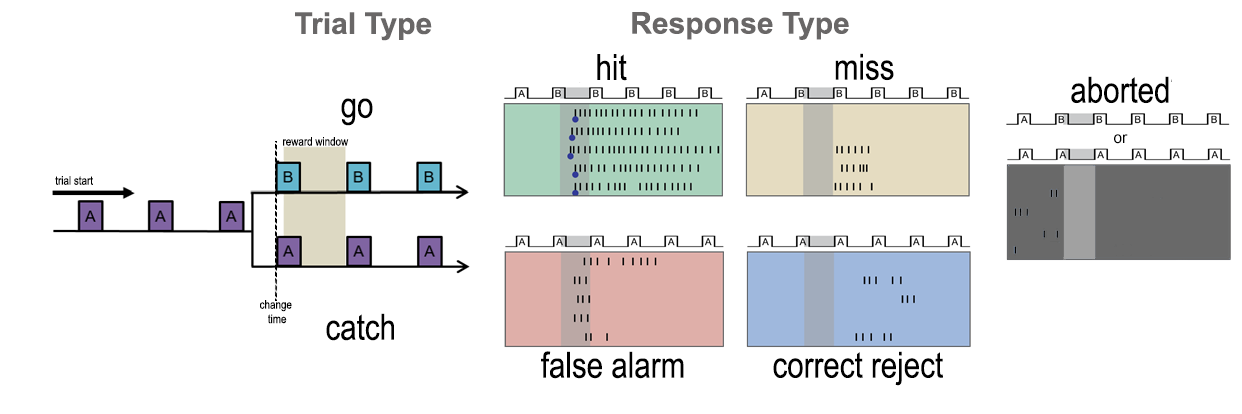
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.1: Explore the trials table</b></p>

<p>1) Get the <code>trials</code> attribute. What are the columns of this dataframe? What are the rows?</p>

<p>2) How many go trials were there? How many catch trials? What is the ratio of go to catch trials?</p>

<p>3) What images were shown? Use the pandas <code>.unique()</code> method to get the unique images from the trials table. </p>
</div>

In [ ]:
# get the trials table 


In [ ]:
# how many trials were there?

In [ ]:
# how many go trials were there? 


In [ ]:
# how many catch trials were there?


In [ ]:
# what images were shown? 
images = ophys_experiment.trials["change_image_name"].unique()
print(images)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.2: Get the hit and false alarm rates for this session</b></p>

<p>The hit rate is the fraction of go trials with a lick in the reward window</p>
    
<p>The false alarm rate is the fraction of catch trials with a lick in the reward window</p>

<p>1) Select all the go trials by filtering the dataframe by <code>go</code> = True. Get the fraction of go trials where <code>hit</code> = True. </p>

<p>2) Repeat for catch trials.</p>

</div>

In [ ]:
# compute the hit rate for go trials
go_trials = trials[trials["go"] == True]
print(len(go_trials), 'go trials')

print(np.sum(go_trials["hit"]), 'hits')
print('hit rate:', round(np.sum(go_trials["hit"])/len(go_trials),2))

In [ ]:
# compute the false alarm rate for catch trials
catch_trials = ophys_experiment.trials[ophys_experiment.trials.catch]
print(len(catch_trials),'catch trials')
print(np.sum(catch_trials.false_alarm),'false alarms')
print('false alarm rate:',round(np.sum(catch_trials.false_alarm)/len(catch_trials),2))

In [ ]:
# did your mouse do a good job at the task? 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 6.3: Plot a lick raster across trials aligned to the change time</b></p>

<p>1) Provide the <code>trials</code> dataframe to the function below to plot a lick raster.</p>

<p>Is the mouse performing the task consistently across the whole session?</p>
</div>

In [ ]:
def make_lick_raster(trials):
    #subset data to remove aborted trials
    trials = trials[trials["aborted"] == False]
    trials = trials.reset_index()
    
    fig,ax = plt.subplots(figsize=(5,10))
    for trial_index, trial_id in enumerate(trials.index.values): 
        trial_data = trials.loc[trial_id]
        # get times relative to change time
        lick_times = [(t - trial_data["change_time"]) for t in trial_data["lick_times"]]
        reward_time = [(t - trial_data["change_time"]) for t in [trial_data["reward_time"]]]
        
        # plot reward times
        if len(reward_time)>0:
               ax.plot(reward_time[0], trial_index + 0.5, 
                    '.', color='b', label='reward', markersize = 6)
        
        # plot lick times
        ax.vlines(lick_times, trial_index, 
                  trial_index + 1, color='k', linewidth=1)
        
        # put a line at the change time
        ax.vlines(0, trial_index, trial_index + 1, 
                  color=[.5, .5, .5], linewidth = 1)
    
    # gray bar for response window
    ax.axvspan(0.1, 0.7, facecolor = 'gray', alpha = .3, edgecolor = 'none')
    ax.grid(False)
    
    
    ax.set_xlim([-1, 4])
    ax.set_ylim(0, len(trials))

    
    ax.set_xlabel('time relative to change (sec)')
    ax.set_ylabel('trials')

    ax.set_title('lick raster')
    plt.gca().invert_yaxis()

In [ ]:
# plot the lick raster for this session using the provided function

make_lick_raster(ophys_experiment.trials)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Reminder:</b>You can find a description of all <code>behavior_session</code> and <code>ophys_experiment</code> attributes, and their columns, in the Visual Behavior cheat sheet or the SDK documentation provided here:</p>
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_CheatSheet.pdf</a></p>  
<p><a href="https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf">https://github.com/AllenInstitute/swdb_2021/tree/main/resources/VisualBehavior2P_SDK_Documentation.pdf</a></p>  
</div>